<a href="https://colab.research.google.com/github/AlbertoBassanoni/MLPNS_ABassanoni/blob/main/generativeAI/EthicsAIaenc_faces_convolutional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

author FBB for EthicsAI2021

# Autoencoder notebook 
create superresolution portraits from low resolution black and white images:
- load a patch of images and lower the resolution
- build an autoencoder with a bottleneck layer much smaller thn the number of pixels in an image
- pass the lower resolution images as imput and the higher resolution images as output
- ask the encoder to predict high resolution images from low resolution ones
- test it on a headshot of yourself

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import backend as K
from keras import Input, Model


In [ ]:
import glob
import h5py
from PIL import Image
import numpy as np
import pylab as pl
from tqdm import tqdm_notebook as tqdm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#cd /content/gdrive/Shareddrives/


In [ ]:
cd /content/gdrive/MyDrive


/content/gdrive/MyDrive


# 1A load head shots from known training data - skip to 1B to load images already read in
The first time you will need to dowbload faces95.zip. Uncomment the 2 lines of code below

In [ ]:
# this link no longer works due to the backlash of the algorithm that whitened Obama
# but I saved the data in our shared drive
#!wget http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip


In [ ]:
#!unzip faces95.zip

In [ ]:
!ls MLPNS2023

faces95			      transformer_h1_history
kaggleTitanic		      transformer_h1_model.h5
model.png		      transformer_h4_history
raw.githubusercontent.com     transformer_h4_model.h5
spm			      wine.data
spm-20210427T111354Z-001.zip  wine.names


In [ ]:
flist = glob.glob("MLPNS2023/faces95/*/*jpg")

In [ ]:
N = len(flist)
N

1441


## read in data

if you save the data in a npy array you can read it in more quickly. After the first time you run this you can comment out the next 2 cells of code and skip to the np.load command

((64, 64, 1), 540)

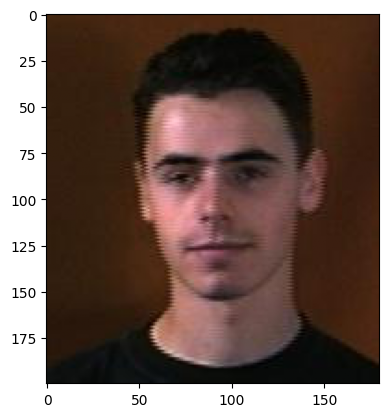

In [ ]:
im = Image.open(flist[40])
np_im = numpy.array(im)[:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_im)
# I am going to need only a subset of the image: the center part where the head is

np_im[25:153:2,25:153:2,:1].shape, np.prod(np_im.shape[1:])

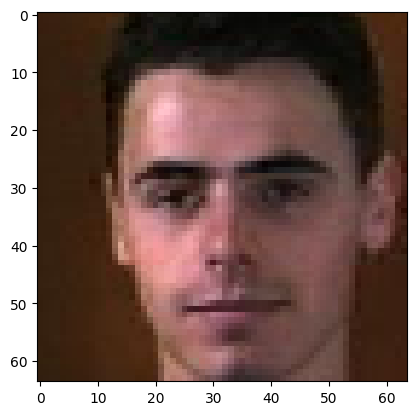

In [ ]:
pl.imshow(np_im[25:153:2,25:153:2])

<font color='red'>you can skip this and go  straight to loading the images</font>

In [ ]:
#skip and read the saved version if you have saved it (after the first time you run this cell)
# I also use a single color channel (black and white)
imgs = np.zeros((N, 64, 64, 1))
for i in tqdm(range(len(flist))):
  im = Image.open(flist[i])
  np_im = numpy.array(im)[:,:,:3].astype(float) / 255 
  # here I collect the certain portion of each image 
  # from pixel 25 to 165 on the x and y axis (25:165)
  # and subsampling by a factor 2 (25:165:2)
  # and I am only choosing 1 color layer: [...,:1]: the R in RGB layers
  imgs[i] = numpy.array(im)[25:153:2,25:153:2,:1].astype(float) / 255 
#uncomment this to save another array of images - I saved the original one as data/faces.npy
#np.save("data/faces_saved.npy", imgs)

<ipython-input-31-15772fae68d3>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(flist))):


  0%|          | 0/1441 [00:00<?, ?it/s]

In [ ]:
np.save("faces_saved.npy", imgs)

# 1B you can read the images below if you have saved them earlier

In [ ]:
imgs = np.load("faces_saved.npy")
imgs.shape

(1441, 64, 64, 1)

## 2 lower the resolution#
keep printing the shape of the images as you go along:

make a copy of the original before you lower the res 

- sample the image every other pixel to get a 35x35 image and only (the shape of the image set should be 1440,35,35,1
- create a 75/25 train/test set with the command 
          train_test_split(input, target, test_size = .25, random_state=1) 
          What are the input and output data??
- the data will be fed as a single row of pixels, so for example each imput image should be reshaped so that  the image array so that eachimage is 35*35 long: reshape the 4 arrays: input training, output training, input test and output test so that they are they are the appropriate shape (each should be Nimages x Npixel)

## Meet me at the enf of that to create the autoencoder.

In [ ]:
#imgs orig is the full resolution image
imgs_orig = imgs.copy()

In [ ]:
# lower the resolution
#imgs_lr = imgs[:,::2,::2]
# slightly better than the line of code above
imgs_lr = imgs.reshape(imgs.shape[0], int(imgs.shape[1]/2), 2, 
                        int(imgs.shape[2]/2), 1, 2
                       ).mean(axis=-1).mean(axis=2)
imgs_lr.shape

(1441, 32, 32, 1)

In [ ]:
#this is the number of pixels in the image
np.prod(imgs_lr[1].shape), np.prod(imgs[1].shape), 

(1024, 4096)

#### generate a train and test set
If I want to predict the image at the same resolution I will pass the same input as the target variable. Otherwise the target variable will be a full resolution image set and the low input the lower resolution one

In [ ]:
from sklearn.model_selection import train_test_split
X_tr,  X_te, y_tr, y_te = train_test_split(imgs_lr, imgs_orig, 
                                             test_size = .20, random_state=1)
  

In [ ]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1152, 32, 32, 1), (289, 32, 32, 1), (1152, 64, 64, 1), (289, 64, 64, 1))

In [ ]:
X_tr[0].shape

(32, 32, 1)

## 3 build an autoencoder model

Remember that the autoencoder is an hour clock model: the center is a smallest layer

for example your NN layers could be 

324 (input size) -> 256 -> 128 -> 56 -> 128 -> 256 -> 1225 (output size)

In [ ]:
model = Sequential()

input_img = Input(shape=X_tr[0].shape)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

model = Model(input_img, decoded)

model.compile(optimizer='adamax', loss='mse', metrics=['mae','acc'])

In [ ]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_79 (Conv2D)          (None, 32, 32, 512)       5120      
                                                                 
 conv2d_80 (Conv2D)          (None, 32, 32, 256)       1179904   
                                                                 
 conv2d_81 (Conv2D)          (None, 32, 32, 128)       295040    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_82 (Conv2D)          (None, 16, 16, 128)       147584    
                                                           

Costruisco un convolutional neural network che funge da encoder.

## 4 A train model OR you can skip and load the pretrained I saved for you! (as long as you did not change the architecture
or to read in the saved model skip this cell, or skip the whole section and read a model from http://fbb.space/mltsa/imgreconstruct_10000.h5

In [ ]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_mae',
                         patience=10,
                         min_delta=0.0001)

In [ ]:
# you can skip this and load the saved model
history = model.fit( X_tr, y_tr, epochs=100000, 
                    validation_data=[X_te, y_te],
                    batch_size=16, verbose=1,
                    callbacks=[callback])
#model.save("imgreconstruct_100000PUS.h5")

Epoch 1/100000
72/72 [==============================] - 16s 41ms/step - loss: 0.0312 - mae: 0.1272 - acc: 0.0020 - val_loss: 0.0097 - val_mae: 0.0692 - val_acc: 0.0046
Epoch 2/100000
72/72 [==============================] - 2s 31ms/step - loss: 0.0074 - mae: 0.0594 - acc: 0.0053 - val_loss: 0.0068 - val_mae: 0.0577 - val_acc: 0.0047
Epoch 3/100000
72/72 [==============================] - 2s 32ms/step - loss: 0.0052 - mae: 0.0484 - acc: 0.0054 - val_loss: 0.0049 - val_mae: 0.0467 - val_acc: 0.0047
Epoch 4/100000
72/72 [==============================] - 2s 34ms/step - loss: 0.0047 - mae: 0.0454 - acc: 0.0054 - val_loss: 0.0045 - val_mae: 0.0435 - val_acc: 0.0047
Epoch 5/100000
72/72 [==============================] - 2s 35ms/step - loss: 0.0040 - mae: 0.0410 - acc: 0.0054 - val_loss: 0.0039 - val_mae: 0.0404 - val_acc: 0.0047
Epoch 6/100000
72/72 [==============================] - 2s 32ms/step - loss: 0.0038 - mae: 0.0394 - acc: 0.0054 - val_loss: 0.0038 - val_mae: 0.0399 - val_acc: 0.00

In [ ]:
#model.save("data/imgreconstruct_10000.h5")

In [ ]:
# READ IN THE SAVED MODEL
#!wget http://fbb.space/mltsa/imgreconstruct_10000.h5
model.load_weights("data/imgreconstruct_10000.h5")

FileNotFoundError: ignored

## predict

In [ ]:
outim = model.predict(X_te)
outim

10/10 [==============================] - 0s 25ms/step


(289, 64, 64, 1)

In [ ]:
def compareinout(i, outim, X_tr):
  '''function to plot the input, the prediction and the target in 3 columns
  plots the ith training datum'''
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(131) 
  ax.imshow(X_te[i].reshape(imgs_lr[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(132) 
  ax.imshow(outim[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(133) 
  ax.imshow(y_te[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


1 :	input			      prediction			    target


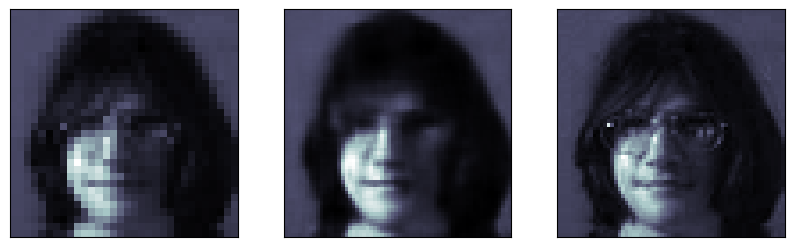

2 :	input			      prediction			    target


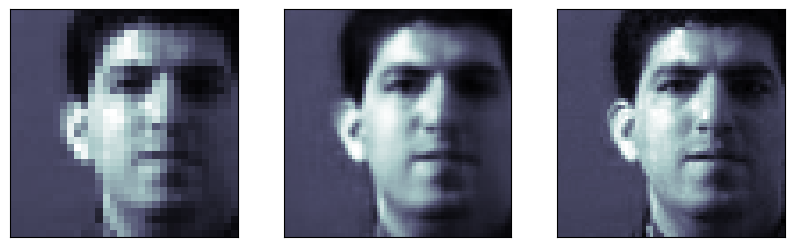

3 :	input			      prediction			    target


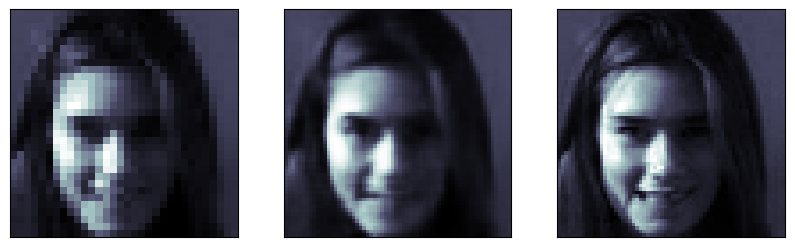

4 :	input			      prediction			    target


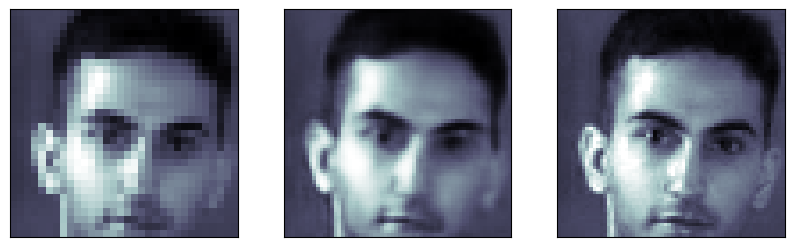

5 :	input			      prediction			    target


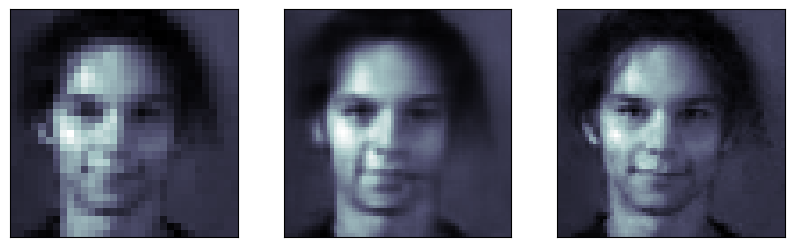

6 :	input			      prediction			    target


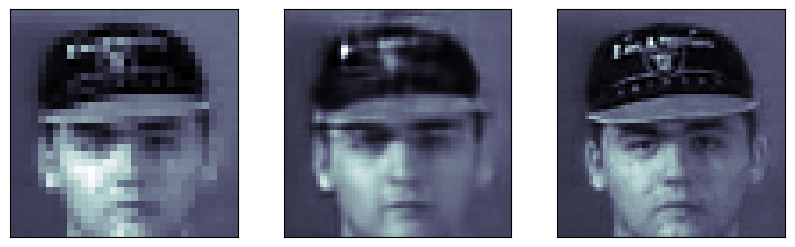

7 :	input			      prediction			    target


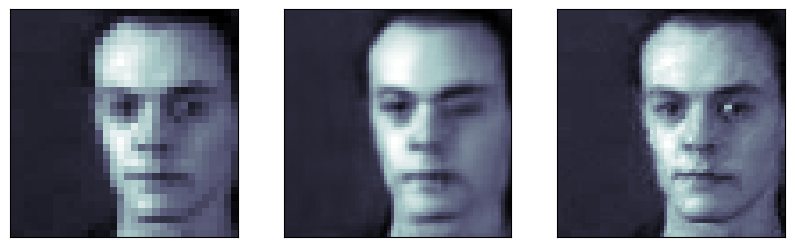

8 :	input			      prediction			    target


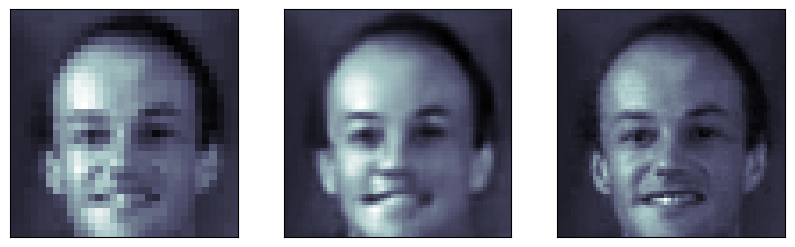

9 :	input			      prediction			    target


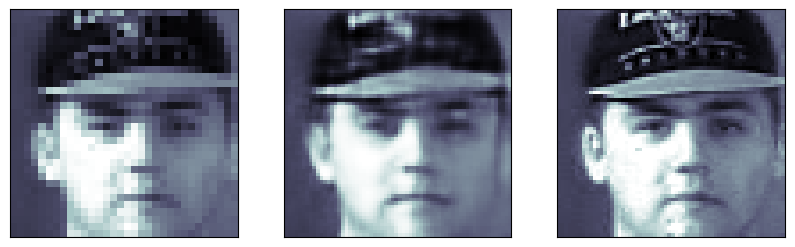

10 :	input			      prediction			    target


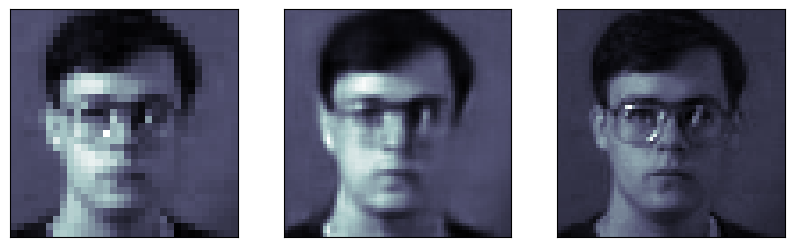

In [ ]:
np.random.seed(302)
# pick a few random test images
for i in range(0, 10, 1):
  j = np.random.randint(0, len(X_te))
  print(i + 1, ":\tinput\t\t\t      prediction\t\t\t    target")
  compareinout(j, outim, X_te)
  pl.show()

What do you think? some are pretty good right?! e.g. 1, 4, 6, 7, 8

Some are really bad. 9... why?

Bisogna capire che generalmente il dataset è di studenti di computer science dell'MIT, e la maggioranza sono uomini maschi bianchi, e quindi il neural network avendo la maggioranza di quei dati quando ha a che fare con la predizione di studenti femmine o di diverso colore di pelle la predizione diventa peggiore. Oppure anche con alcune foto "scentrate" il neural network non sa che cosa fare! 

Quindi, i neural network sono molto buoni per intrapolare, ma non estrapolare! Ovverosia se tutti gli elementi del mio dataset sono adatti e similari, allora il mio neural network funziona bene. Se invece ci sono outliers (in questo caso studenti femmine o di diverso colore di pelle) il neural network generativo non sa fare una buona predizione. 

Fondamentalmente, il problema è: dobbiamo sempre essere sicuri che il nostro training set sia balanced!

# test the model on your own image
 depending on the initial size you will have to downsample the image, and extract a single color layer

In [ ]:
from google.colab import files
from io import BytesIO
from PIL import Image
uploaded = files.upload()


Saving foto profilo mia.jpg to foto profilo mia.jpg


In [ ]:
file_contents = uploaded[list(uploaded.keys())[0]]


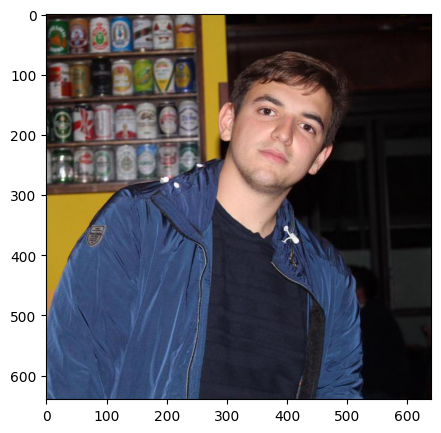

In [ ]:
imme = Image.open(BytesIO(file_contents))
plt.imshow(imme)

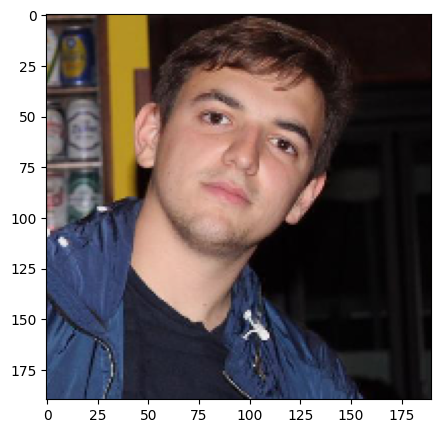

In [ ]:
np_im = numpy.array(imme)[::2,::2,:3].astype(float) /270
pl.figure()
pl.imshow(np_im[30:220,100:290,:] )
np_im[30:220,100:290,:].shape, np.prod(np_im.shape[1:]);


low resolution version
subsampling by 15

In [ ]:
np_im_me = np_im[30:220,100:290,:][::6,::6,1]
np_im_me_4=np_im_me.reshape(1,32,32,1)
np_im_me_4.shape

(1, 32, 32, 1)

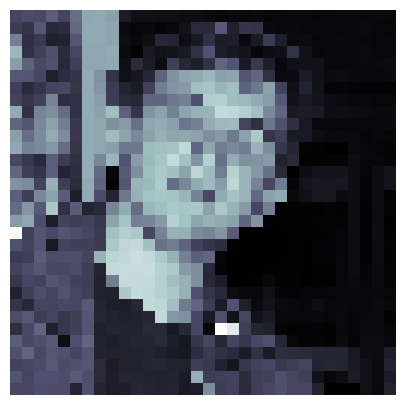

In [ ]:
pl.imshow(np_im_me, cmap="bone")
pl.axis('off');

1/1 [==============================] - 0s 28ms/step


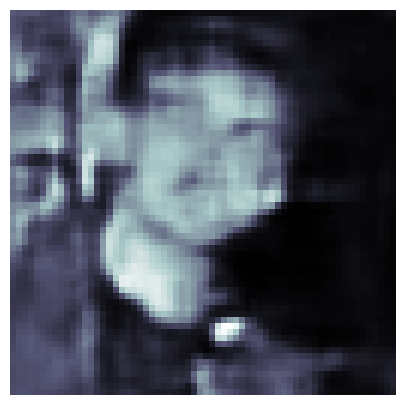

In [ ]:
pl.imshow((model.predict(np_im_me_4)).reshape(64,64), 
          cmap="bone")
pl.axis('off');